In [1]:
#
# 2017-08-31
#
# XGB - решение - дурняк, но работает
#
#
#

In [2]:
import sys, os, math, datetime
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
def dataClean( df ) :
    def cn (cc) : 
        cc = np.reshape(cc.values,(len(df)))
        return([jj for jj,dd in enumerate(cc.tolist()) if dd ])
    ##df=df.fillna(0.0)
    badly = np.zeros((len(df)),dtype=np.int32)
    ##cols  = df.columns.tolist()
    ##print(cols)
    for ii,nn in enumerate(df.columns.tolist()) :
        
        if (ii==0) and (nn.startswith('Chloro')) : # Chlorophyl
            cc = ((df[[ii]]<0.0) | (df[[ii]]>1.0))
            df.iloc[cn(cc),ii] = 0.0
            #badly[cn(cc)] += 1
        
        if (ii==1) and (nn.startswith('Depth')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==3) and (nn.startswith('Eastward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==4) and (nn.startswith('Latitude')) :
            cc = (df[[ii]]< -90.0);      df.iloc[cn(cc),ii] = -90.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  90.0);      df.iloc[cn(cc),ii] =  90.0; badly[cn(cc)] += 1
        
        if (ii==5) and (nn.startswith('Longitude')) :
            cc = (df[[ii]]< -180.0);      df.iloc[cn(cc),ii] = -180.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  180.0);      df.iloc[cn(cc),ii] =  180.0; badly[cn(cc)] += 1
        
        if (ii==6) and (nn.startswith('Northward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==7) and (nn.startswith('Oceanic')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==8) and (nn.startswith('SOG')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==9) and (nn.startswith('Salinity')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==10) and (nn.startswith('Sea')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==11) and (nn.startswith('Speed')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1

        if (ii==11) and (nn.startswith('Thermocline')) : 
            cc = (df[[ii]]<     0.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

        if (ii==15) and (nn.startswith('Water')) : 
            cc = (df[[ii]]<  -100.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

    print(cc.sum(),badly.sum())
    return(badly)

In [4]:
# Читаем train список
train_list = pd.read_csv('../Data/training.txt', header=None)
train_list.columns=['trackfile','typing']

In [5]:
train_list.head()

,trackfile,typing
0,100047,trawler
1,100070,longliner
2,100080,seiner
3,100093,other
4,100144,trawler


In [6]:
y_class = train_list['typing'].unique().tolist(); y_class

['trawler', 'longliner', 'seiner', 'other', 'support']

In [7]:
# Читаем test список
test_list = pd.read_csv('../Data/testing.txt', header=None)
test_list.columns=['trackfile']
print 'test length:',len(test_list)
test_list.head()

test length: 1211


,trackfile
0,100015
1,100045
2,100060
3,100112
4,100131


In [541]:
# Построение массива с данными по списку файлов

def buildX (file_list, nFiles=-1, maxSpeed=35.0, rWindow=5, hTimeMin=False, hTimeMax=False, fillOK=False) :
    
    for ii,ffile in enumerate(file_list) :
        if ii==nFiles : break
        xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
        
        ##print(ii,ffile)
        
        # Small corrections: (latitude&longitude), timing
        
        xx = xx[(xx.Latitude >=-90.0)  & (xx.Latitude <= 90.0)];
        xx = xx[(xx.Longitude>=-180.0) & (xx.Longitude<=180.0)];
        
        xx['Time']  = xx[[1]]
        xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
        xx['hTime'] = xx.sTime/3600.0
        
        if hTimeMin : 
            xx          = xx[xx.hTime>=hTimeMin]
            xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
            xx['hTime'] = xx.sTime/3600.0
            
        havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
        havLo       = (0.5*(1.0-np.cos(-xx.Longitude.diff(-1)/180.0*math.pi))).fillna(0.0)

        cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)

        hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
        dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)

        xx['Distance'] = dist
        xx['Speed']    = np.round((dist/1.852/xx.hTime).fillna(0.0),2)
        xx.loc[xx.Speed>maxSpeed,'Speed'] = maxSpeed
        
        if hTimeMax : 
            xx.sTime[xx.hTime<=hTimeMax] = 0.0
            xx.hTime[xx.hTime<=hTimeMax] = 0.0
        
        # rolling Speed
        rSpeed = xx.Distance.rolling(window=rWindow, min_periods=1).mean()
        rSpeed = (rSpeed/xx.hTime).fillna(0.0)
        xx['rSpeed'] = np.round(np.clip(rSpeed,0.0,maxSpeed),2)

        if fillOK : xx = xx.fillna(fillOK)

        if (ii==0) : resAll = xx.copy()
        else       : resAll = resAll.append(xx.copy())

    ##print(trainAll.shape)
    return (resAll)

def buildY (file_list, y_classes) :
    
    trainIndex=file_list.copy()
    trainIndex['y'] = np.array(map(y_classes.index,trainIndex.typing.tolist()))
    return(trainIndex)

In [544]:
print datetime.datetime.now()
trainAll_ = buildX(train_list['trackfile'].values.tolist(), nFiles=12) #, hTimeMin=5.0/3600);
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(trainAll_.Latitude.min(), trainAll_.Latitude.max(), trainAll_.Longitude.min(), 
                  trainAll_.Longitude.max(), len(trainAll_.TrackNumber.unique()),  trainAll_.shape))
print datetime.datetime.now()
##len(trainAll_.TrackNumber.unique()),trainAll_.TrackNumber.unique(),trainAll_.tail()

2017-09-04 01:39:50.834822
	Latitudes: between -67.458415 and 56.720937 
	Longitudes: between -179.67688 and 179.980242 
	Files=12 Shapes=(68343, 19)
2017-09-04 01:39:51.104943


In [545]:
trainAll_.describe()

,TrackNumber,Time(seconds),Latitude,Longitude,SOG,oceanic depth,Chlorophyll Concentration,Salinity,Water Surface Elevation,Sea Temperature,Thermocline Depth,Eastward Water Velocity,Northward Water Velocity,Time,sTime,hTime,Distance,Speed,rSpeed
count,68343.000000,6.834300e+04,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,6.834300e+04,6.834300e+04,68343.000000,68343.000000,68343.000000,68343.000000
mean,100177.603003,3.823745e+06,39.738107,-19.413192,1.510658,-208.938823,-44208.527856,30.038326,-5.191575,4.830204,169.833471,-4.268868,-4.348623,3.823745e+06,1.355213e+03,0.376448,3.105737,2.578414,7.250289
std,79.937088,2.384120e+06,20.018974,79.004114,382.551771,421.545481,49663.762562,662.754271,662.521443,662.693920,667.332902,662.526826,662.526270,2.384120e+06,1.697947e+04,4.716520,133.617179,4.445773,11.243540
min,100047.000000,0.000000e+00,-67.458415,-179.676880,-99999.000000,-1532.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,100093.000000,1.544225e+06,37.388433,-9.366658,0.000000,-76.000000,-99999.000000,34.000000,-1.760000,-0.800000,136.100000,-0.060000,-0.100000,1.544225e+06,6.100000e+01,0.016944,0.001481,0.010000,0.020000
50%,100144.000000,4.021559e+06,51.415543,8.310493,0.100000,-5.000000,0.145500,34.200000,-1.370000,1.400000,169.000000,0.150000,0.050000,4.021559e+06,4.050000e+02,0.112500,0.004308,0.050000,0.670000
75%,100277.000000,5.945117e+06,53.993879,8.709229,3.600000,0.000000,0.683000,34.700000,-0.010000,14.400000,173.800000,0.310000,0.150000,5.945117e+06,9.300000e+02,0.258333,0.360720,3.200000,9.910000
max,100287.000000,7.948470e+06,56.720937,179.980242,16.800000,132.000000,3.902200,35.800000,0.770000,31.300000,1109.600000,1.160000,1.040000,7.948470e+06,2.163149e+06,600.874722,12436.947142,35.000000,35.000000


In [546]:
print datetime.datetime.now()
trainAll_ = buildX(train_list['trackfile'].values.tolist(), hTimeMin=2.0/(60.0*60.0));
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(trainAll_.Latitude.min(), trainAll_.Latitude.max(), trainAll_.Longitude.min(), 
                  trainAll_.Longitude.max(), len(trainAll_.TrackNumber.unique()),  trainAll_.shape))
trainAll  = trainAll_
trainAll.to_csv('../Data/trainingAllNew.csv',index=False)
del trainAll_
print datetime.datetime.now()

2017-09-04 01:42:54.542483
	Latitudes: between -89.798397 and 89.64788 
	Longitudes: between -179.999883 and 179.999953 
	Files=1209 Shapes=(7338688, 20)
2017-09-04 01:54:17.337841


In [547]:
len(train_list['trackfile'].values.tolist())

1209

In [548]:
trainAll = pd.read_csv('../Data/trainingAllNew.csv')

In [549]:
#trainWeights = dataClean(trainAll)

In [550]:
!ls -la ../Data
trainAll.shape

total 3129100
drwxrwxrwx 1 boba boba       4096 сен  4 00:29 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  2 02:54 testingAll.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba 1034904477 сен  4 01:54 trainingAllNew.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks


(7338688, 20)

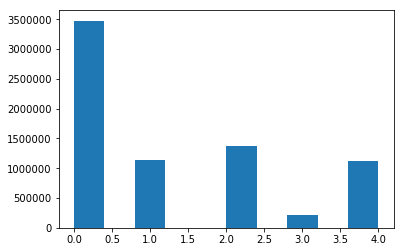

,TrackNumber,Chlorophyll Concentration,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,...,Speed,Thermocline Depth,Time,Time(seconds),Water Surface Elevation,hTime,oceanic depth,rSpeed,sTime,y
0,100047,0.3105,3.186329,0.06,41.101078,1.235355,0.01,NaN,7.4,34.3,...,6.65,111.0,0,0,-0.22,0.258611,-4.0,12.32,931.0,0
1,100047,0.3043,5.981159,0.06,41.074507,1.221120,0.02,NaN,5.1,34.3,...,9.01,109.5,931,931,-0.22,0.358333,-11.0,12.79,1290.0,0
2,100047,0.3059,8.779740,0.06,41.043652,1.279553,0.04,NaN,10.2,34.3,...,10.33,117.4,2221,2221,-0.23,0.458889,-16.0,13.04,1652.0,0
3,100047,0.3674,0.000095,0.08,40.998603,1.365502,0.07,NaN,10.5,34.3,...,0.05,123.8,3873,3873,-0.24,0.001111,-46.0,35.00,4.0,0
4,100047,0.3674,7.221329,0.08,40.998602,1.365502,0.07,NaN,10.5,34.3,...,9.92,123.8,3877,3877,-0.24,0.393056,-46.0,13.57,1415.0,0


In [551]:
trainIndex = buildY(train_list,y_class)
train      = trainAll.set_index('TrackNumber')
train['y'] = trainIndex.set_index('trackfile').y
train      = train.reset_index()
plt.hist(train.y); plt.show(); plt.close()
train.head()

In [215]:
hTimeMin = 3.0/3600.0
hTimeMax = 48.0

OKtrain = ((train.hTime<=hTimeMax) & (train.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)

In [552]:
import xgboost as xgb

In [553]:
train_x = train.drop(['y','TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
train_y = train.y.values  #[:1000000]

mtrain = xgb.DMatrix(train_x,label=train_y)

In [556]:
# Добавляем веса, чтобы не удалять записи из массива
if 0 :
    temp = (0.0+train_x.shape[1]-1.5*trainWeights)/train_x.shape[1]
    mtrain.set_weight(temp)
    trainWeights.min(), trainWeights.max()
    plt.hist(temp,bins=50); plt.show()
    temp.min(),temp.max(), train_x.shape, trainWeights.min(), trainWeights.max()

In [557]:
train_y.shape, train_x.shape, train_x.columns.tolist(), train_y.max()

((7338688,),
 (7338688, 17),
 ['Chlorophyll Concentration',
  'Distance',
  'Eastward Water Velocity',
  'Latitude',
  'Longitude',
  'Northward Water Velocity',
  'Oceanic Depth',
  'SOG',
  'Salinity',
  'Sea Temperature',
  'Speed',
  'Thermocline Depth',
  'Water Surface Elevation',
  'hTime',
  'oceanic depth',
  'rSpeed',
  'sTime'],
 4)

In [558]:
##import sklearn as sk
##from sklearn.model_selection import cross_val_score

In [559]:
##cross_val_score(estimator=xgb.XGBClassifier(), X=train_x, y=train_y, cv=5, scoring='accuracy')

In [560]:
parms = {'reg':'logistic'}
parms = {'multi':'softmax','num_class':5,'metrics':'mlogloss'}
#parms = {'num_class':5,'metrics':'mlogloss'}
parms['objective'] = 'multi:softprob'
parms['eval_metric'] = ['merror','mlogloss']
parms['silent'] = 0

evallist  = [(mtrain,'train')]
##parms = {'reg':'logistic'}
##parms = {'reg':'linear','metrics':'auc'}

##hist = xgb.cv(parms,mtrain,num_boost_round=30,nfold=5,early_stopping_rounds=4,verbose_eval=True,metrics='mlogloss')
#hist = xgb.train(parms,mtrain,num_boost_round=30,early_stopping_rounds=5)

In [561]:
#xgbmodel = xgb.train(parms,mtrain,num_boost_round=1) # empty nodel

In [563]:
print datetime.datetime.now()
xgbmodel = xgb.train(parms,mtrain,num_boost_round=100, evals=evallist)# , xgb_model=xgbmodel) # = 100
print datetime.datetime.now()

2017-09-04 01:58:44.739724
[0]	train-merror:0.188388	train-mlogloss:1.18469
[1]	train-merror:0.176316	train-mlogloss:0.964504
[2]	train-merror:0.166748	train-mlogloss:0.818045
[3]	train-merror:0.161255	train-mlogloss:0.714693
[4]	train-merror:0.157774	train-mlogloss:0.639099
[5]	train-merror:0.153191	train-mlogloss:0.581267
[6]	train-merror:0.147907	train-mlogloss:0.53591
[7]	train-merror:0.146035	train-mlogloss:0.501471
[8]	train-merror:0.144649	train-mlogloss:0.474095
[9]	train-merror:0.141146	train-mlogloss:0.450455
[10]	train-merror:0.137013	train-mlogloss:0.4295
[11]	train-merror:0.134887	train-mlogloss:0.414655
[12]	train-merror:0.131931	train-mlogloss:0.401138
[13]	train-merror:0.129426	train-mlogloss:0.388167
[14]	train-merror:0.12749	train-mlogloss:0.378334
[15]	train-merror:0.1242	train-mlogloss:0.368934
[16]	train-merror:0.121165	train-mlogloss:0.359636
[17]	train-merror:0.119468	train-mlogloss:0.352236
[18]	train-merror:0.118114	train-mlogloss:0.345518
[19]	train-merror:0.1

In [564]:
#xgbmodel.load_model('../Work/xgbModel.bst')
##xgbmodel.load_model('../Work/xgbModelClean.bst')
##xgbmodel.save_model('../Work/xgbModelCleanSoftProb.bst')
##xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-200.bst')
#xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-400.bst')
#xgbmodel = xgb.Booster()
#xgbmodel.load_model('../Work/xgbModel-NotClean-SoftProb-400.bst')
xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-New-100.bst')

In [565]:
pred_y = xgbmodel.predict(mtrain); ##pred_y[-20:],pred_y.max()

In [566]:
pred_y.shape, pred_y.max() #pred_y[:4]

((7338688, 5), 0.99998975)

In [567]:
pred_y_softmax=pred_y.argmax(axis=1); pred_y_softmax.shape

(7338688,)

In [568]:
((pred_y_softmax==train_y).sum()/float(len(pred_y)))

0.94517902927607766

In [569]:
df_diff = pd.DataFrame(train.TrackNumber,columns=['TrackNumber'])
df_diff['true_y'] = np.array(train_y,dtype=np.uint8)
df_diff['pred_y'] = np.array(pred_y_softmax, dtype=np.uint8)

df_diff['OK']    = df_diff.true_y==df_diff.pred_y

#print(df_diff.head())

len(df_diff)-df_diff.OK.sum()
aa = df_diff.groupby(['TrackNumber','OK']).size().reset_index(); aa.columns=['TrackNumber','OK','ccount']; aa.head()
bb = pd.DataFrame(train.TrackNumber.unique(),columns=['TrackNumber'])
bb['xx'] = 1.0; bb=bb.set_index(['TrackNumber'])
cc = aa[['TrackNumber','ccount']][aa.OK==True];  cc.head(); cc = cc.set_index(['TrackNumber']); bb['Yes']=cc
cc = aa[['TrackNumber','ccount']][aa.OK==False]; cc.head(); cc = cc.set_index('TrackNumber'); bb['No'] =cc
bb=bb.reset_index().drop('xx',axis=1).fillna(0)
print(bb.head())
float(len(bb[bb.No>bb.Yes]))/len(bb)*100.0

   TrackNumber      Yes     No
0       100047    650.0    0.0
1       100070    154.0  242.0
2       100080   9667.0   95.0
3       100093   5209.0  294.0
4       100144  15427.0    0.0


5.707196029776675

In [570]:
#trainAll.describe()

In [571]:
#testAll.describe()

In [573]:
fimp  = xgbmodel.get_fscore();
ffimp = [[k,fimp[k]] for k in fimp.keys()]; 
ffimp.sort(key=lambda x: x[1],reverse=True)
tempsum = 0
for temp in ffimp : tempsum+=temp[1];
##print(tempsum)
for ii,temp in enumerate(ffimp) : 
    ffimp[ii][1] = float(ffimp[ii][1])/tempsum*100.0;
ffimp

[['Longitude', 16.33182336871953],
 ['Latitude', 14.118745461461323],
 ['Oceanic Depth', 12.327535530274215],
 ['SOG', 8.824648155192088],
 ['Water Surface Elevation', 6.072132508039697],
 ['Sea Temperature', 5.944188941526332],
 ['Chlorophyll Concentration', 5.615685189667693],
 ['Salinity', 5.124658528994779],
 ['Eastward Water Velocity', 4.865313461737958],
 ['Thermocline Depth', 4.561015249489954],
 ['Northward Water Velocity', 3.980082298834676],
 ['Speed', 3.4060652166395795],
 ['oceanic depth', 2.883917147895847],
 ['hTime', 2.2269096441785674],
 ['Distance', 2.195788236107749],
 ['rSpeed', 1.5214910612400152]]

In [594]:
y_class, trainIndex[trainIndex.trackfile==100093].typing

(['trawler', 'longliner', 'seiner', 'other', 'support'], 3    other
 Name: typing, dtype: object)

In [359]:
hTimeMin = 10.0/3600.0
hTimeMax = 48.0

OKtrain = ((train.hTime<=hTimeMax) & (train.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)

In [358]:
if 0 :
    train_o          = train.copy()
    pred_y_o         = pred_y.copy()
    pred_y_softmax_o = pred_y_softmax.copy()
if 1 :
    train            = train_o.copy()
    pred_y           = pred_y_o.copy()
    pred_y_softmax   = pred_y_softmax_o.copy()
len(train), len(pred_y), len(pred_y_softmax)

(8080623, 8080623, 8080623)

In [360]:
train          = train[OKtrain]
pred_y         = pred_y[OKtrain]
pred_y_softmax = pred_y_softmax[OKtrain]

In [577]:
len(train), len(pred_y), len(pred_y_softmax)

(7338688, 7338688, 7338688)

   TrackNumber  pred_y        pr
0       100047       0  1.000000
1       100070       0  0.005051
2       100070       1  0.388889
3       100070       2  0.606061
4       100080       1  0.001332


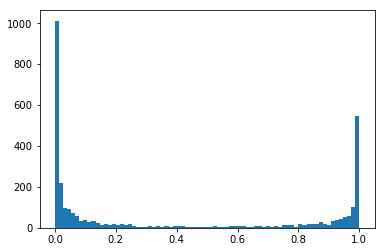

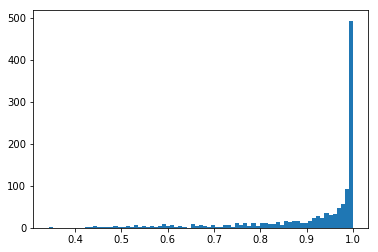

64

In [591]:
ppred = pd.DataFrame()
ppred['TrackNumber'] = train.TrackNumber
ppred['pred_y']      = pred_y_softmax
ppred['true_y']      = train.y

g0pred = ppred.groupby(['TrackNumber','pred_y']).size()
g1pred = ppred.groupby(ppred.TrackNumber).size(); #print(len(g1pred),g1pred.head())
temp   = np.round(g0pred/g1pred,6)
g0pred = g0pred.reset_index()
g0pred.columns = ['TrackNumber','pred_y','pr']
g0pred['pr'] = temp.values
print(g0pred.head())

g2pred = g0pred.reset_index()
g2pred = g2pred.pr.groupby(g2pred.TrackNumber).max()
plt.hist(g0pred.pr,bins=75); plt.show()
plt.hist(g2pred,bins=75); plt.show()
#g0pred
g2pred.head()
len(g2pred[g2pred<0.60])

In [592]:
#Построение train-решения через probs без времени, только частотность

g100     = pd.DataFrame(pred_y); g100.head(), g100.columns
g100pred = g100.groupby(ppred.TrackNumber).sum(); g100pred.head()
temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6); 
g100pred.head()
if 1 :
    for nn in g100pred.columns : g100pred[nn][g100pred[nn]<=0.05] = 0.0;
    temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);

temp = g100pred.stack()
temp = temp[temp>0.0]
g100pred = pd.DataFrame(temp.reset_index());
g100pred.columns=['TrackNumber','pred_y','pr']
del temp
g100pred.head(30), g100pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0        100047       0  1.000000
 1        100070       1  0.435718
 2        100070       2  0.564282
 3        100080       2  1.000000
 4        100093       0  0.068533
 5        100093       3  0.931467
 6        100144       0  1.000000
 7        100161       1  1.000000
 8        100175       0  1.000000
 9        100204       0  0.819592
 10       100204       1  0.180408
 11       100216       0  0.123321
 12       100216       3  0.876679
 13       100262       0  1.000000
 14       100277       2  1.000000
 15       100287       0  1.000000
 16       100305       0  1.000000
 17       100321       0  0.894700
 18       100321       3  0.105300
 19       100362       1  0.417451
 20       100362       2  0.582549
 21       100370       0  1.000000
 22       100380       1  0.052043
 23       100380       2  0.812453
 24       100380       4  0.135505
 25       100383       0  0.229668
 26       100383       1  0.066111
 27       100383    

In [595]:
g110     = pd.DataFrame(pred_y) # в работе время 
for nn in g110.columns : g110[nn] = np.round(g110[nn]*0.5*(train.sTime+train.sTime.shift().fillna(0.0)),6);
    
g110pred = g110.groupby(ppred.TrackNumber).sum(); g110pred.head()
temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);
if 1 :
    for nn in g110pred.columns : g110pred[nn][g110pred[nn]<=0.05] = 0.0;
    temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
    for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);

g110pred.head(15)

temp = g110pred.stack()
temp = temp[temp>0.0]
g110pred = pd.DataFrame(temp.reset_index());
g110pred.columns=['TrackNumber','pred_y','pr']
del temp
g110pred.head(20), g110pred.pred_y.dtype, g110pred.pr.max()

(    TrackNumber  pred_y        pr
 0        100047       0  1.000000
 1        100070       0  0.087667
 2        100070       1  0.424272
 3        100070       2  0.488061
 4        100080       2  1.000000
 5        100093       0  0.195962
 6        100093       3  0.804038
 7        100144       0  1.000000
 8        100161       1  1.000000
 9        100175       0  1.000000
 10       100204       0  0.712207
 11       100204       1  0.214264
 12       100204       3  0.073529
 13       100216       0  0.056983
 14       100216       3  0.943017
 15       100262       0  1.000000
 16       100277       1  0.054715
 17       100277       2  0.945285
 18       100287       0  1.000000
 19       100305       0  1.000000, dtype('int64'), 1.0)

In [597]:
ggtrain = pd.DataFrame(train[['TrackNumber','y']].groupby(['TrackNumber','y']).size().reset_index()); ggtrain.head()
ggtrain.columns   = ['TrackNumber','pred_y','size']
ggtrain['true_y'] = 1.0
ggtrain.head()

,TrackNumber,pred_y,size,true_y
0,100047,0,650,1.0
1,100070,1,396,1.0
2,100080,2,9762,1.0
3,100093,3,5503,1.0
4,100144,0,15427,1.0


In [598]:
#ggtrain  = ggtrain.reset_index()
#g100pred = g100pred.reset_index()
#gg.reset_index()

In [600]:
#ggtrain  = ggtrain.set_index(['TrackNumber','pred_y'])
#g100pred = g100pred.set_index(['TrackNumber','pred_y']) 
gg = pd.merge(g0pred.reset_index(),ggtrain,how='outer',suffixes=('_x','_y'),on=('TrackNumber','pred_y'))
gg = gg.drop('size',axis=1).fillna(0.0)
print(gg.tail(15))
ggBad = gg[(gg.pr!=gg.true_y) & (gg.pr<0.50) & (gg.true_y>0.50)]['TrackNumber'].unique(); ggBad
##gg.set_index('TrackNumber')
ggBadTracks = gg.set_index('TrackNumber').loc[ggBad.tolist(),:].reset_index().TrackNumber.unique()
print len(ggBadTracks), ggBadTracks.tolist()
##gg.reset_index()
#ggtrain.pred_y.dtype
#g100pred.pred_y.dtype

       index  TrackNumber  pred_y        pr  true_y
3129  3129.0       132644       1  0.005981     0.0
3130  3130.0       132644       2  0.975650     1.0
3131  3131.0       132644       4  0.018369     0.0
3132  3132.0       132653       0  0.975450     1.0
3133  3133.0       132653       2  0.024550     0.0
3134  3134.0       132759       1  0.003389     0.0
3135  3135.0       132759       2  0.982300     1.0
3136  3136.0       132759       4  0.014311     0.0
3137     0.0       104192       4  0.000000     1.0
3138     0.0       109405       0  0.000000     1.0
3139     0.0       110948       0  0.000000     1.0
3140     0.0       112859       2  0.000000     1.0
3141     0.0       124127       0  0.000000     1.0
3142     0.0       127152       3  0.000000     1.0
3143     0.0       129194       2  0.000000     1.0
69 [100070, 100362, 102260, 102762, 104138, 104805, 104893, 105633, 106490, 107032, 107328, 107417, 107682, 108128, 108140, 108738, 110845, 112232, 112290, 112306, 1138

In [601]:
gg.head()
gg.set_index('TrackNumber').loc[124127,:]
#ggBad.tolist()
train[train.TrackNumber==124127].iloc[:,:] #range(7)+[9,10,11,12,13,14,16,17,18,19,20]]
#train[train.TrackNumber==131933].iloc[:,range(4)+[5,8,9,11,12,13,14,16,17,18,19,20]]

,TrackNumber,Chlorophyll Concentration,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,...,Speed,Thermocline Depth,Time,Time(seconds),Water Surface Elevation,hTime,oceanic depth,rSpeed,sTime,y
5377278,124127,-99999.0,0.002271,0.09,43.658698,-7.352898,0.33,-6.0,0.0,34.4,...,0.00,317.4,0,0,-0.31,0.251111,NaN,0.01,904.0,0
5377279,124127,-99999.0,0.003463,0.09,43.658692,-7.352925,0.33,-6.0,0.0,34.4,...,0.01,317.3,904,904,-0.31,0.280278,NaN,0.01,1009.0,0
5377280,124127,-99999.0,0.279200,0.09,43.658672,-7.352958,0.33,-6.0,0.0,34.4,...,0.00,317.2,1913,1913,-0.31,582.999722,NaN,0.00,2098799.0,0
5377281,124127,-99999.0,0.004969,0.30,43.657407,-7.349960,-0.06,-6.0,0.0,34.3,...,0.01,198.2,2100712,2100712,-0.23,0.263333,NaN,0.36,948.0,0
5377282,124127,-99999.0,0.005168,0.30,43.657378,-7.350007,-0.06,-6.0,0.0,34.3,...,0.01,198.1,2101660,2101660,-0.23,0.261389,NaN,0.37,941.0,0
5377283,124127,-99999.0,0.005193,0.30,43.657382,-7.349943,-0.06,-6.0,0.0,34.3,...,0.01,198.1,2102601,2102601,-0.23,0.263889,NaN,0.02,950.0,0
5377284,124127,-99999.0,0.002563,0.30,43.657395,-7.350005,-0.06,-6.0,0.0,34.3,...,0.01,197.9,2103551,2103551,-0.23,0.261389,NaN,0.02,941.0,0
5377285,124127,-99999.0,0.000000,0.30,43.657418,-7.350007,-0.06,-6.0,0.0,34.3,...,0.00,197.8,2104492,2104492,-0.23,0.000000,NaN,35.00,0.0,0


In [217]:
# Готовим решение по test

In [54]:
for ii,ffile in enumerate((test_list['trackfile'].values.tolist())): # [:10]) :
    xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
    xx['Time']  = xx[[1]]
    xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
    xx['hTime'] = xx.sTime/3600.0
    xx['Depth'] = xx[[5]]
    
    havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    havLo       = (0.5*(1.0-np.cos(-xx.Longitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    
    cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)
    
    hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
    dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)
    
    xx['Distance'] = dist
    xx['Speed']    = (dist/1.852/xx.hTime).fillna(0.0)
    
    xx = xx.fillna(0.0)
    
    if (ii==0) : testAll = xx.copy()
    else : testAll = testAll.append(xx.copy())
        
print(testAll.shape)

(6586899, 20)


In [55]:
#testAll.to_csv('../Data/testingAll.csv',index=False)

In [382]:
testAll = pd.read_csv('../Data/testingAll.csv')

In [34]:
#testWeights = dataClean(testAll)

In [383]:
!ls -la ../Result
!ls -la ../Data
!ls -la ../Work
testAll.shape

total 77
drwxrwxrwx 1 boba boba  4096 сен  1 21:36 .
drwxrwxrwx 1 boba boba  4096 сен  1 16:12 ..
drwxrwxrwx 1 boba boba     0 сен  1 21:36 Best
-rwxrwxrwx 1 boba boba 66869 сен  3 15:25 bobaFish.csv
-rwxrwxrwx 1 boba boba   413 сен  1 16:53 FishingForFishermen2.java
drwxrwxrwx 1 boba boba     0 сен  1 16:36 .ipynb_checkpoints
total 2118448
drwxrwxrwx 1 boba boba       4096 сен  1 15:28 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  2 02:54 testingAll.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks
total 54564
drwxrwxrwx 1 boba boba     4096 сен  3 02:49 .
drwxrwxrwx 1 boba boba     4096 сен  1 16:12 ..
drwxrwxrwx 1 boba boba        0 сен  3 02:09 .ipynb_checkpoints
-rwxrwxrwx 1 boba boba  9910843 сен  1 22:55 xgbModel.bst
-rwxrwxrwx 1 boba boba 10

(6586899, 20)

In [384]:
test_x = testAll.drop(['TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
mtest  = xgb.DMatrix(test_x)
test_x.shape

(6586899, 17)

In [385]:
test_y = xgbmodel.predict(mtest); ##pred_y[-20:],pred_y.max()

In [386]:
test_y_softmax = test_y.argmax(axis=1); test_y_softmax.shape

(6586899,)

In [387]:
test = testAll

In [388]:
if 0 :
    test_o           = test.copy()
    test_y_o         = test_y.copy()
    test_y_softmax_o = test_y_softmax.copy()
if 1 :
    test             = test_o.copy()
    test_y           = test_y_o.copy()
    test_y_softmax   = test_y_softmax_o.copy()
len(test), len(test_y), len(test_y_softmax)

(6586899, 6586899, 6586899)

In [389]:
test           = test[OKtest]
test_y         = test_y[OKtest]
test_y_softmax = test_y_softmax[OKtest]
len(test), len(test_y), len(test_y_softmax)

(5432594, 5432594, 5432594)

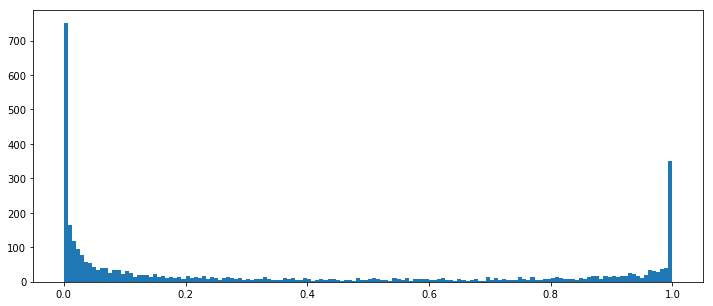

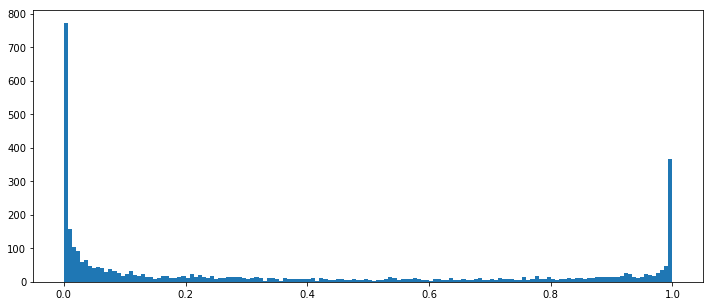

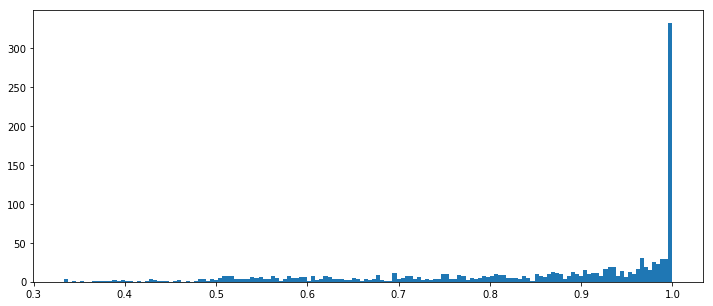

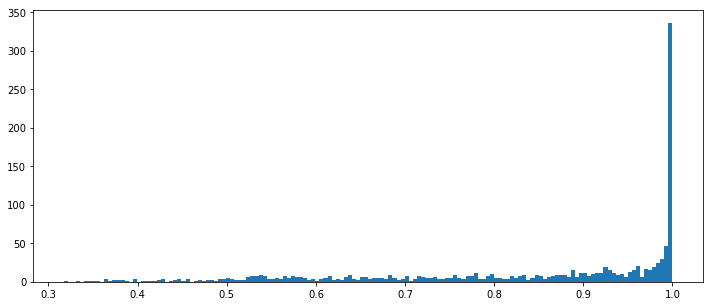

165 1e-06 1.0 0.0 1.0 2e-06 1.0


In [390]:
# Распределение результата test
ppred = pd.DataFrame()
ppred['TrackNumber'] = test.TrackNumber
ppred['pred_y'] = np.array(test_y_softmax,dtype=np.uint8)
##print(ppred.head())

tySize = ppred.groupby(['TrackNumber','pred_y']).size();
tSize  = ppred.groupby(['TrackNumber']).size();

g0pred = pd.DataFrame(np.round(tySize/tSize,4)).reset_index()   # common result table [Track#, pred#, prob]
g0pred.columns=['TrackNumber','pred_y','pr']

##print('Common result \n',g0pred.head())

ggmax, g4pred = [], g0pred.groupby('TrackNumber')

for tt in g0pred.TrackNumber.unique().tolist() :
    aa = g4pred.get_group(tt)
    ggmax.append(aa.pred_y[aa.pr.argmax()])

##print(len(ggmax),ggmax[:40])

g1pred = pd.DataFrame(g0pred.TrackNumber.unique())   # table only one max result for Track# [Track#, pred#, prob]
g1pred['pred_y'] = np.array(ggmax)
g1pred['pr']     = 1.0
g1pred.columns=['TrackNumber','pred_y','pr']

##print 'Only result pred = 1.0 \n',g1pred.head()

g2pred = ppred.copy()
g2pred['sTime']  = testAll.sTime
g2pred['sTimeX'] = testAll.sTime.shift()
g2pred = g2pred.fillna(0)

g2pred = g2pred.groupby(['TrackNumber','pred_y']).sum();
g2pred['ssTime'] = (g2pred.sTime+g2pred.sTimeX)*0.5
ttSize = g2pred.reset_index().groupby(['TrackNumber']).sum();
g2pred['prS']  = np.round(g2pred.sTime/ttSize.sTime,6)
g2pred['prX']  = np.round(g2pred.sTimeX/ttSize.sTimeX,6)
g2pred['prSX'] = np.round(g2pred.ssTime/ttSize.ssTime,6)
g2pred['pr']   = g2pred.prSX

##print g2pred.head(20)




g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#

plt.figure(figsize=(12,5)); plt.hist(g0pred.pr,bins=150); plt.show()
plt.figure(figsize=(12,5)); plt.hist(g2pred.prSX,bins=150); plt.show()

g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()

print len(g3pred[g3pred<0.60]), g2pred.prS.min(), g2pred.prS.max(), g2pred.prX.min(), g2pred.prX.max(), g2pred.prSX.min(), g2pred.prSX.max()

In [391]:
#Построение решение через probs

g100     = pd.DataFrame(test_y); g100.head(), g100.columns
g100pred = g100.groupby(ppred.TrackNumber).sum(); g100pred.head()
temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);
if 1 :
    for nn in g100pred.columns : g100pred[nn][g100pred[nn]<=0.05] = 0.0;
    temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);

g100pred.head(15)

temp = g100pred.stack()
temp = temp[temp>0.0]
g100pred = pd.DataFrame(temp.reset_index());
g100pred.columns=['TrackNumber','pred_y','pr']
del temp
g100pred.head(20), g100pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0      100015.0       0  0.076917
 1      100015.0       1  0.695514
 2      100015.0       2  0.227569
 3      100045.0       0  1.000000
 4      100060.0       0  0.397893
 5      100060.0       1  0.360745
 6      100060.0       2  0.241362
 7      100112.0       0  0.889375
 8      100112.0       1  0.110625
 9      100131.0       0  0.789677
 10     100131.0       1  0.091003
 11     100131.0       3  0.119320
 12     100150.0       1  0.655002
 13     100150.0       4  0.344998
 14     100151.0       0  0.379270
 15     100151.0       1  0.169667
 16     100151.0       2  0.118293
 17     100151.0       4  0.332770
 18     100215.0       1  0.241689
 19     100215.0       4  0.758311, dtype('int64'))

In [397]:
g110     = pd.DataFrame(test_y)
for nn in g110.columns : g110[nn] = np.round(g110[nn]*0.5*(testAll.sTime+testAll.sTime.shift().fillna(0.0)),6);
    
g110pred = g110.groupby(ppred.TrackNumber).sum(); g110pred.head()
temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);
if 1 :
    for nn in g110pred.columns : g110pred[nn][g110pred[nn]<=0.05] = 0.0;
    temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
    for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);

g110pred.head(15)

temp = g110pred.stack()
temp = temp[temp>0.0]
g110pred = pd.DataFrame(temp.reset_index());
g110pred.columns=['TrackNumber','pred_y','pr']
del temp
g110pred.head(20), g110pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0      100015.0       0  0.098532
 1      100015.0       1  0.743994
 2      100015.0       2  0.157474
 3      100045.0       0  1.000000
 4      100060.0       0  0.133880
 5      100060.0       1  0.505930
 6      100060.0       2  0.360190
 7      100112.0       0  1.000000
 8      100131.0       0  0.790099
 9      100131.0       1  0.081707
 10     100131.0       3  0.128194
 11     100150.0       1  0.588748
 12     100150.0       4  0.411252
 13     100151.0       0  0.349287
 14     100151.0       1  0.282810
 15     100151.0       2  0.107583
 16     100151.0       4  0.260320
 17     100215.0       1  0.313375
 18     100215.0       4  0.686625
 19     100221.0       1  0.241171, dtype('int64'))

In [396]:
#
# Построение решения из softProbs взвешенное временем до-после точки --> 874xxx
# 2 подход: -очистка, 200 раундов, отсутствие весов --> 880536.69
# 3 подход: --------  400 раундов --> 878101.38
# 4 подход: без взвешивания по времени, только среднее по точкам, 400 раундов --> 886230.54
# 5 подход: только softmax + выброс плохих точек, 400 раундов --> 885310.33
#
test_r = g110pred.copy()
test_r = g100pred.copy() # 4 step
test_r = g0pred.copy() # 5 step
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(20))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType      pr
0        100015     trawler  0.0285
1        100015   longliner  0.8327
2        100015      seiner  0.1388
3        100045     trawler  0.9998
4        100045      seiner  0.0002
5        100060     trawler  0.0492
6        100060   longliner  0.7203
7        100060      seiner  0.2300
8        100060     support  0.0006
9        100112     trawler  1.0000
10       100131     trawler  0.9611
11       100131   longliner  0.0014
12       100131       other  0.0375
13       100150   longliner  0.9439
14       100150      seiner  0.0530
15       100150     support  0.0032
16       100151     trawler  0.1217
17       100151   longliner  0.0082
18       100151      seiner  0.0341
19       100151     support  0.8359


In [84]:
g0pred.head()
test_r = g0pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(15))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType      pr
0        100015     trawler  0.0376
1        100015   longliner  0.8243
2        100015      seiner  0.1368
3        100015       other  0.0013
4        100045     trawler  1.0000
5        100060     trawler  0.0532
6        100060   longliner  0.7423
7        100060      seiner  0.2039
8        100060     support  0.0005
9        100112     trawler  1.0000
10       100131     trawler  0.8094
11       100131   longliner  0.0029
12       100131       other  0.1877
13       100150   longliner  0.9298
14       100150      seiner  0.0642


In [112]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (+-) вероятности типов судов
#  2017-09-02 +- хуже 886xxx -> 870xxx
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prSX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.123381
1        100015   longliner  0.796768
2        100015      seiner  0.068208
3        100015       other  0.011644
4        100045     trawler  1.000000
5        100060     trawler  0.111688
6        100060   longliner  0.816666
7        100060      seiner  0.071583
8        100060     support  0.000063
9        100112     trawler  1.000000
10       100131     trawler  0.798129
11       100131   longliner  0.047469
12       100131       other  0.154402
13       100150   longliner  0.917904
14       100150      seiner  0.074431
15       100150     support  0.007665
16       100151     trawler  0.371117
17       100151   longliner  0.012507
18       100151      seiner  0.019218
19       100151     support  0.597159
20       100215     trawler  0.026426
21       100215   longliner  0.025318
22       100215      seiner  0.948256
23       100221     trawler  1.000000
24       100227     trawler  0.999765


In [113]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (- предыдущее время) вероятности типов судов
#  2017-09-02 - 870xxx->863xxx
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.101394
1        100015   longliner  0.837527
2        100015      seiner  0.051816
3        100015       other  0.009262
4        100045     trawler  1.000000
5        100060     trawler  0.092662
6        100060   longliner  0.848095
7        100060      seiner  0.059195
8        100060     support  0.000048
9        100112     trawler  1.000000
10       100131     trawler  0.798759
11       100131   longliner  0.047166
12       100131       other  0.154074
13       100150   longliner  0.917502
14       100150      seiner  0.075145
15       100150     support  0.007353
16       100151     trawler  0.370181
17       100151   longliner  0.014386
18       100151      seiner  0.019686
19       100151     support  0.595747
20       100215     trawler  0.048802
21       100215   longliner  0.002205
22       100215      seiner  0.948993
23       100221     trawler  1.000000
24       100227     trawler  0.999768


In [373]:
#  2017-09-01 Почему-то дает провал на 511650.89 с 890501, хотя не должна?
# Only max predictions pr<-1.0
g1pred.head()
test_r = g1pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head())
##test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

   TrackNumber FishingType   pr
0       100015   longliner  1.0
1       100045     trawler  1.0
2       100060   longliner  1.0
3       100112     trawler  1.0
4       100131     trawler  1.0


In [42]:
##test_yy = xgbmodel.predict(mtest, pred_contribs=True)
xgb.__version__

'0.6'

In [273]:
xgbmodel.attributes()

{}

In [82]:
bbins = [aa for aa in range(49)] + [max(trainAll.hTime.max(),trainAll.hTime.max(),)+1.0]

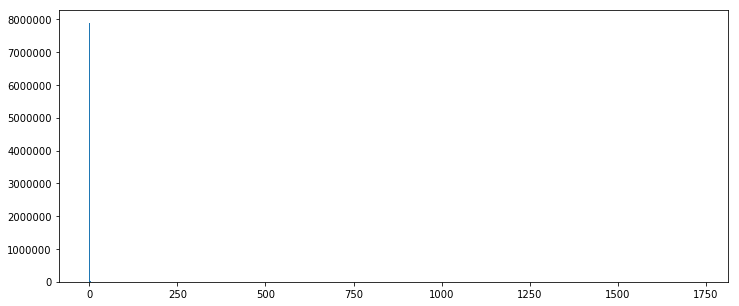

In [87]:
plt.figure(figsize=(12,5)); hh, bb, _ = plt.hist(trainAll.hTime,bins=bbins); plt.show()

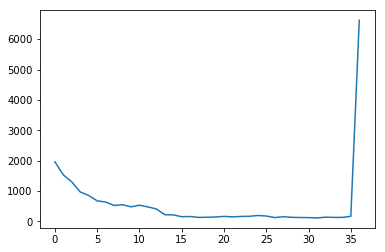

(50, 10596.0, array([  6.41767600e+06,   7.81920000e+04,   1.72610000e+04,
          1.02150000e+04,   7.46600000e+03,   6.46400000e+03,
          6.23000000e+03,   7.07300000e+03,   6.33900000e+03,
          4.01400000e+03,   2.76100000e+03,   2.11200000e+03,
          1.96100000e+03,   1.53100000e+03,   1.30000000e+03,
          9.69000000e+02,   8.53000000e+02,   6.78000000e+02,
          6.38000000e+02,   5.25000000e+02,   5.50000000e+02,
          4.81000000e+02,   5.35000000e+02,   4.78000000e+02,
          4.11000000e+02,   2.22000000e+02,   2.16000000e+02,
          1.55000000e+02,   1.63000000e+02,   1.33000000e+02,
          1.38000000e+02,   1.46000000e+02,   1.66000000e+02,
          1.51000000e+02,   1.64000000e+02,   1.69000000e+02,
          1.96000000e+02,   1.78000000e+02,   1.28000000e+02,
          1.56000000e+02,   1.35000000e+02,   1.30000000e+02,
          1.26000000e+02,   1.16000000e+02,   1.40000000e+02,
          1.33000000e+02,   1.33000000e+02,   1.69000000e

In [96]:
plt.plot(hh[12:]); plt.show()
len(bb), hh[24:].sum(), hh, bb

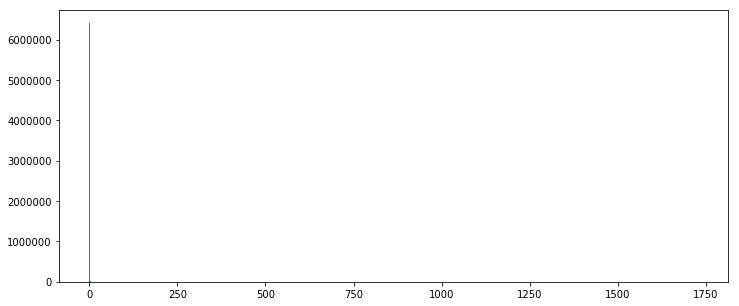

In [95]:
plt.figure(figsize=(12,5)); hh, bb, _ = plt.hist(testAll.hTime,bins=bbins); plt.show()

In [369]:
hTimeMin = 3.0/3600.0
hTimeMax = 48.0

hTimeMin = 10.0/3600.0
hTimeMax = 48.0

OKtrain = ((trainAll.hTime<=hTimeMax) & (trainAll.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)
OKtest  = ((testAll.hTime<=hTimeMax) & (testAll.hTime>hTimeMin))
NOtest  = np.logical_not(OKtest)


print('All tracks: \ttrain={}, test={}\nTracks with wrong records:  \ttrain={}, test={}\nTracks with good records:  \ttrain={}, test={}'. \
          format(len(trainAll.TrackNumber.unique()),len(testAll.TrackNumber.unique()), \
                 len(trainAll.TrackNumber[NOtrain].unique()), \
                 len(testAll.TrackNumber[NOtest].unique()), \
                 len(trainAll.TrackNumber[OKtrain].unique()), \
                 len(testAll.TrackNumber[OKtest].unique())))

All tracks: 	train=1209, test=1211
Tracks with wrong records:  	train=1209, test=1211
Tracks with good records:  	train=1209, test=1211


In [157]:
print('train={}, test={}'.format(len(trainAll.TrackNumber[((trainAll.hTime>hTimeMax) | (trainAll.hTime<hTimeMin))]),
                                 len(testAll.TrackNumber[((testAll.hTime>hTimeMax) | (testAll.hTime<hTimeMin))] ) ))

train=938990, test=658466


In [133]:
train[train.hTime> 48.0]

,TrackNumber,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,...,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),Water Surface Elevation,hTime,oceanic depth,sTime,y
69,100047,0.3114,-4,0.635781,-0.04,41.099857,1.232748,-0.03,NaN,8.9,...,10.6,0.005562,113.6,210835,210835,-0.21,61.726111,-4.0,222214.0,0
93,100047,0.3095,-5,0.905187,-0.21,41.107890,1.238818,-0.10,NaN,0.0,...,10.2,0.004476,123.8,643825,643825,-0.19,109.190278,-5.0,393085.0,0
179,100047,0.3043,-10,3.923416,-0.04,41.078055,1.213548,0.01,NaN,10.6,...,9.9,0.034441,263.1,1420301,1420301,-0.17,61.510556,-10.0,221438.0,0
251,100047,0.3043,-10,2.912001,0.10,41.082810,1.215468,0.04,NaN,10.7,...,9.8,0.025526,323.8,2024705,2024705,-0.21,61.597778,-10.0,221752.0,0
297,100047,0.3092,-5,3.436802,0.05,41.104813,1.239307,0.11,NaN,0.5,...,9.6,0.029979,157.6,2629425,2629425,-0.29,61.900000,-5.0,222840.0,0
359,100047,0.2080,-4,2.703458,-0.06,41.088820,1.221198,0.05,NaN,9.4,...,9.6,0.023528,252.4,3232398,3232398,-0.30,62.043333,-4.0,223356.0,0
418,100047,0.2047,-5,0.207280,-0.12,41.108707,1.240357,0.29,NaN,0.0,...,9.6,0.001338,380.1,3759683,3759683,-0.23,83.626111,-5.0,301054.0,0
453,100047,0.2042,-5,2.327180,-0.12,41.104318,1.241150,0.17,NaN,0.8,...,9.7,0.020191,184.3,4442169,4442169,-0.24,62.235278,-5.0,224047.0,0
473,100047,0.2092,-3,0.086283,0.00,41.083383,1.215767,0.10,NaN,7.3,...,9.9,0.000745,252.4,5046051,5046051,-0.25,62.506389,-3.0,225023.0,0
495,100047,0.1735,-5,3.308095,-0.02,41.105027,1.242002,0.18,NaN,8.4,...,9.8,0.028623,229.6,5651446,5651446,-0.26,62.406389,-5.0,224663.0,0
